## Asycronous clients

This example illustrates how one can work with asyncronous clients using FEDn.

In [22]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from fedn import APIClient
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import copy

### ML model

As a centralized model baseline we generate synthetic data for a classification problem based on 4 features. We train a MLPClassifier on 80k training points, and test on 20k using ReLU activation, and Adam as optimizer, using a maximum of 1000 epochs.   

In [51]:
X, y = make_classification(n_samples=100000, n_features=4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
from client.entrypoint import compile_model, load_parameters 

clf = compile_model(max_iter=1000)
clf.fit(X, y)
central_test_acc = accuracy_score(y_test, clf.predict(X_test))

print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
print("Test accuracy: ", accuracy_score(y_test, clf.predict(X_test)))

Training accuracy:  0.8746
Test accuracy:  0.87325


We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports.

In [2]:
DISCOVER_HOST = '127.0.0.1'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

Next, we retrive all model validations from all clients, extract the training accuracy metric, and compute its mean value accross all clients

In [13]:
# You can retrive storage_config from the database
storage_config = {
        'storage_hostname': 'localhost',
        'storage_port': 9000,
        'storage_access_key': 'fedn_admin',
        'storage_secret_key': 'password',
        'storage_bucket': 'fedn-models',
        'context_bucket': 'fedn-context',
        'storage_secure_mode': False
    }

from fedn.network.storage.s3.repository import Repository 
from fedn.utils.helpers.helpers import get_helper
    
def load_fedn_model(model_id):

    r = Repository(storage_config)
    data = r.get_model(model_id)
    with open('temp.npz','wb') as fh:
        fh.write(data)
    
    parameters = load_parameters('temp.npz')
    
    model = compile_model()
    n = len(parameters)//2
    model.coefs_ = parameters[:n]
    model.intercepts_ = parameters[n:]
    return model
    

Traverse the model trail and plot test accuracy on the central test set

In [70]:
model_trail = client.get_model_trail()
models = []
dates = []
for key, value in model_trail.items():
    models.append(key)
    dates.append(value)

indx = np.argsort(dates)

acc = []
for i in indx: 
    model = load_fedn_model(models[i])
    acc.append(accuracy_score(y_test, model.predict(X_test)))

2024-03-15 16:12:42 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:12:42 [INFO] Client MINIORepository trying to get model with id: f894c414-7143-49f9-8878-56a0468e1bd4
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-03-15 16:12:42 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:12:42 [INFO] Client MINIORepository trying to get model with id: 78f8a9c1-16bd-478e-adfb-fe06624aa8b2
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-03-15 16:12:42 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:12:43 [INFO] Client MINIORepository trying to get model wit

2024-03-15 16:12:47 [INFO] Client MINIORepository trying to get model with id: 3d297063-a6c6-4e98-a9e5-9f306ed20615
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-03-15 16:12:47 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:12:47 [INFO] Client MINIORepository trying to get model with id: 79ab66bf-10d4-4308-98a5-af87e085542a
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-03-15 16:12:47 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:12:47 [INFO] Client MINIORepository trying to get model with id: 6ca0614b-66c2-47ac-9647-6741de76a705
/Users/andreash/miniforge3

/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-03-15 16:12:52 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:12:52 [INFO] Client MINIORepository trying to get model with id: 9d3123d8-5836-4634-9cfd-4c3a24cbc954
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-03-15 16:12:52 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:12:52 [INFO] Client MINIORepository trying to get model with id: 5a30f347-dffa-472a-888e-586b44351fde
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic O

2024-03-15 16:12:57 [INFO] Client MINIORepository trying to get model with id: af488976-9bf2-4f3e-afda-8f1cecc711b2
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-03-15 16:12:57 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:12:57 [INFO] Client MINIORepository trying to get model with id: 76ad0906-241e-4163-b0f8-2a06de0730c4
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-03-15 16:12:57 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:12:57 [INFO] Client MINIORepository trying to get model with id: 67ab6ece-87e7-493a-9333-20a536b137ec
/Users/andreash/miniforge3

/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-03-15 16:13:01 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:13:01 [INFO] Client MINIORepository trying to get model with id: 64dac382-e9bd-4e45-9b69-641f5f388c12
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-03-15 16:13:01 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:13:02 [INFO] Client MINIORepository trying to get model with id: 256305e9-7f00-4424-9f1a-7c602a8b0284
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic O

2024-03-15 16:13:06 [INFO] Client MINIORepository trying to get model with id: d2453976-c513-4847-bd50-87a88bb02ee2
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-03-15 16:13:06 [WARNING] S3/MINIO RUNNING IN **INSECURE** MODE!
2024-03-15 16:13:06 [INFO] Client MINIORepository trying to get model with id: f1a217a9-2749-404b-9507-f2d9c08085d8
/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Plot the result.

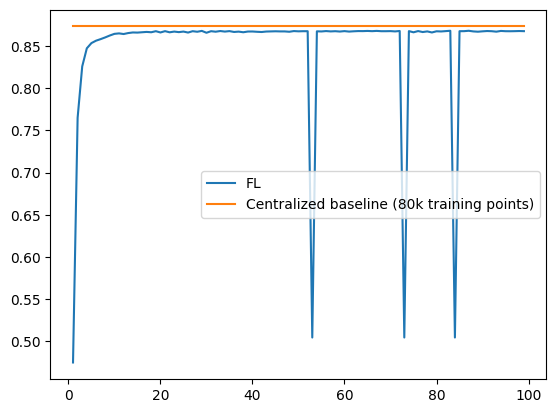

In [71]:
x = range(1,len(acc)+1)
plt.plot(x, acc)
plt.plot(x,[central_test_acc]*len(x))
plt.legend(['FL','Centralized baseline (80k training points)'])